In [1]:
#reproduce fig 3c wgcna analysis table

In [ ]:
import numpy as np
import nibabel as nb
import os
import matplotlib.pyplot as plt
from wgcna_module_enrichments import WGCNApostprocessing
import pandas as pd
fetal=False
adult=False
combi=True

proc = WGCNApostprocessing()

print('eigengenes')
concat= np.load('/data1/allen_surfaces/hcp_surfs_2/all_subs_smoothed_z.npy')

base_dir = '/data1/allen_surfaces/'
cortex=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k','Glasser_2016.32k.L.label.gii'))
cortex=cortex.darrays[0].data>0
concat_cortex = concat[:,cortex]
proc.get_kme_and_eigengenes(concat_cortex)
del concat_cortex
del concat


proc.calc_filtered_modules()

proc.filter_out_genes_and_modules()

print('enrichments')
matrices=[]
matrices_for_clustering = ['Layer','Cell','Compartment',
                        'SynGO' ]
labels=[]
for m in matrices_for_clustering:
    f_mat,p_mat = proc.get_enrichment_for_prefix(m)
    matrices.append(p_mat)
    label = proc.generate_labels_from_prefixes(m)
    labels.append(label)

#here we're actually doing it from a previous ordering. Not ideal, but hey ho
order_matrices = np.hstack(matrices[:3])
new_order=proc.reorder_modules_from_similarity(order_matrices,
                                              from_file='/data1/bigbrain/phate_testing/wgcna/new_order.npy')
print('gradients')
proc.filter_eigengenes_and_grads(new_order)
print('plotting')
proc.plot_eigengenes_and_gradients()
proc.get_dict_modules()

module_labels=list(proc.dictionary_modules.keys())

In [ ]:
anatomy_matrices, anatomy_names=proc.anatomical_map_tests()
network_matrices, network_names=proc.network_tests()
ppi_mat=proc.get_ppis()

main_labels = [anatomy_names]+[network_names]+labels[:4]+[['PPI']]
combi_under_labels = ['Macro\nanatomy',
            'Functional\nnetworks',
            'Layer marker\ngenes', 'Adult cell\nmarker genes', 'Cellular\ncompartments',
            '','Protein\npathways','Peak\nEpoch','Fetal\nCompartment','Fetal cell\nmarker genes']


fetal_gene_lists = ['BrainVar_PeakEpoch','Fetal layer','Fetal_cell'
                          ]
fetal_matrices=[]
fetal_labels = []
for m in fetal_gene_lists:
    f_mat,p_mat = proc.get_enrichment_for_prefix(m)
    fetal_matrices.append(p_mat)
    label = proc.generate_labels_from_prefixes(m)
    fetal_labels.append(label)
reorder = np.array([0,0,1,1,1,1,0], dtype=bool)
reorder_fetal = np.array([1,1,1], dtype=bool)
combi_reorder = np.hstack([reorder,reorder_fetal])
fetal_labels[0]=['1: Prenatal','2: Perinatal',
'3:Postnatal']

combi_matrices = [anatomy_matrices.T]+[network_matrices]+matrices[:4]+[ppi_mat.reshape(-1,1)]+fetal_matrices

combi_labels = [anatomy_names]+[network_names]+labels[:4]+[['PPI']] + fetal_labels

In [ ]:
for mi, mat in enumerate(combi_matrices):
    if combi_reorder[mi]:
        matrices[mi]=matrices[mi][proc.new_order]

In [ ]:
ps=np.load('../neurosynth/p_vals.npy')
terms=np.load('../neurosynth/terms.npy',allow_pickle=True)
pcorr=np.load('../neurosynth/p_vals_corr.npy')


In [ ]:
def network_f_tests(self):
        import paths as p
        a=nb.load(os.path.join(p.fs_LR32k_dir,'Schaefer2018_500Parcels_7Networks_order.dlabel.nii'))
        parcellation=a.dataobj[:].ravel()[:len(self.cortex)]
        filename=os.path.join(p.fs_LR32k_dir,'Schaefer2018_500Parcels_7Networks_order_info.txt')
        data = ['A_wall'];
        cnt = 0;
        with open(filename, 'r') as infile:
            for line in infile:
                if cnt%2 == 0:
                    data.append(line.split('_')[2])
                cnt+=1
        network_names= np.unique(data)
        network_parcellation=np.zeros(len(parcellation),dtype=int)
        for ni,network in enumerate(data):
            network_parcellation[parcellation==ni]=np.where(network_names==network)[0]
        
        dummies=np.array(pd.get_dummies(network_parcellation))[self.cortex].T[1:].astype(bool)
        sphere = nb.load('/data1/allen_surfaces/hcp_surfs/standard_mesh_atlases/L.sphere.32k_fs_LR.surf.gii')
        coords=sphere.darrays[0].data
        coms=[]
        for com in np.unique(parcellation)[1:]:
            coms.append(np.mean(coords[parcellation==com],axis=0))
        coms=np.array(coms)
        spins_schaefer = self.generate_spins(coms,np.zeros(len(coms)),n_iter=1000)
        labels = np.array(data[1:251])
        n_perm=1000
        parcelled = self.parcellate(parcellation[self.cortex],
                                    self.full_eigengenes_filtered[:,self.cortex],exclude=0)
        deltas = np.zeros((self.full_eigengenes_filtered.shape[0],len(network_names)-1))
        perm_deltas= np.zeros((n_perm,self.full_eigengenes_filtered.shape[0],len(network_names)-1))
        for ni,network in enumerate(network_names[1:]):
            deltas[:,ni] = np.mean(parcelled[labels==network],axis=0)
            for sp in np.arange(n_perm):
                spun = parcelled[spins_schaefer[:,sp]]
                perm_deltas[sp,:,ni]=np.mean(spun[labels==network],axis=0)
        p_vals = np.mean(deltas<perm_deltas,axis=0)
        #reorder
        network_order=np.array([6,5,2,4,3,0,1])

        network_names = np.array(['Frontoparietal','Default',
                                  'Dorsal Attention','Limbic','Ventral Attention',
                                  'Somatomotor','Visual'])
        return p_vals[:,network_order], network_names[network_order]

In [ ]:
if combi:
    anatomy_matrices, anatomy_names=proc.anatomical_map_tests()
    network_matrices, network_names=proc.network_tests()
    ppi_mat=proc.get_ppis()
    
    main_labels = [anatomy_names]+[network_names]+labels[:4]+[['PPI']]
    combi_under_labels = ['Macro\nanatomy',
                'Functional\nnetworks',
                'Layer marker\ngenes', 'Cell marker\ngenes', 'Cellular\ncompartments',
                '','Protein\npathways','Peak\nEpoch','Fetal\nCompartment','Fetal Cell']
    
    fetal_gene_lists = ['BrainVar_PeakEpoch','Fetal layer','Fetal_cell'
                              ]
    fetal_matrices=[]
    fetal_labels = []
    for m in fetal_gene_lists:
        f_mat,p_mat = proc.get_enrichment_for_prefix(m)
        fetal_matrices.append(p_mat)
        label = proc.generate_labels_from_prefixes(m)
        fetal_labels.append(label)
    reorder = np.array([0,0,1,1,1,1,0], dtype=bool)
    reorder_fetal = np.array([1,1,1], dtype=bool)
    combi_reorder = np.hstack([reorder,reorder_fetal])
    fetal_labels[0]=['1: Prenatal','2: Perinatal',
    '3:Postnatal']
                               
    combi_matrices = [anatomy_matrices.T]+[network_matrices]+matrices[:4]+[ppi_mat.reshape(-1,1)]+fetal_matrices
                      
    combi_labels = [anatomy_names]+[network_names]+labels[:4]+[['PPI']] + fetal_labels
    fig_fetal = proc.main_fig(combi_matrices,combi_labels,
             proc.combined_eigengenes,
                module_labels,
                combi_under_labels,
                   combi_reorder,
             proc.new_order,
                         reflected_maps=False
            )


In [15]:
combi_under_labels = ['Macro\nanatomy',
                'Functional\nnetworks',
                'Layer marker\ngenes', 'Adult cell\nmarker genes', 'Cellular\ncompartments',
                '','Protein\npathways','Peak\nEpoch','Fetal\nCompartment','Fetal cell\nmarker genes']

/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


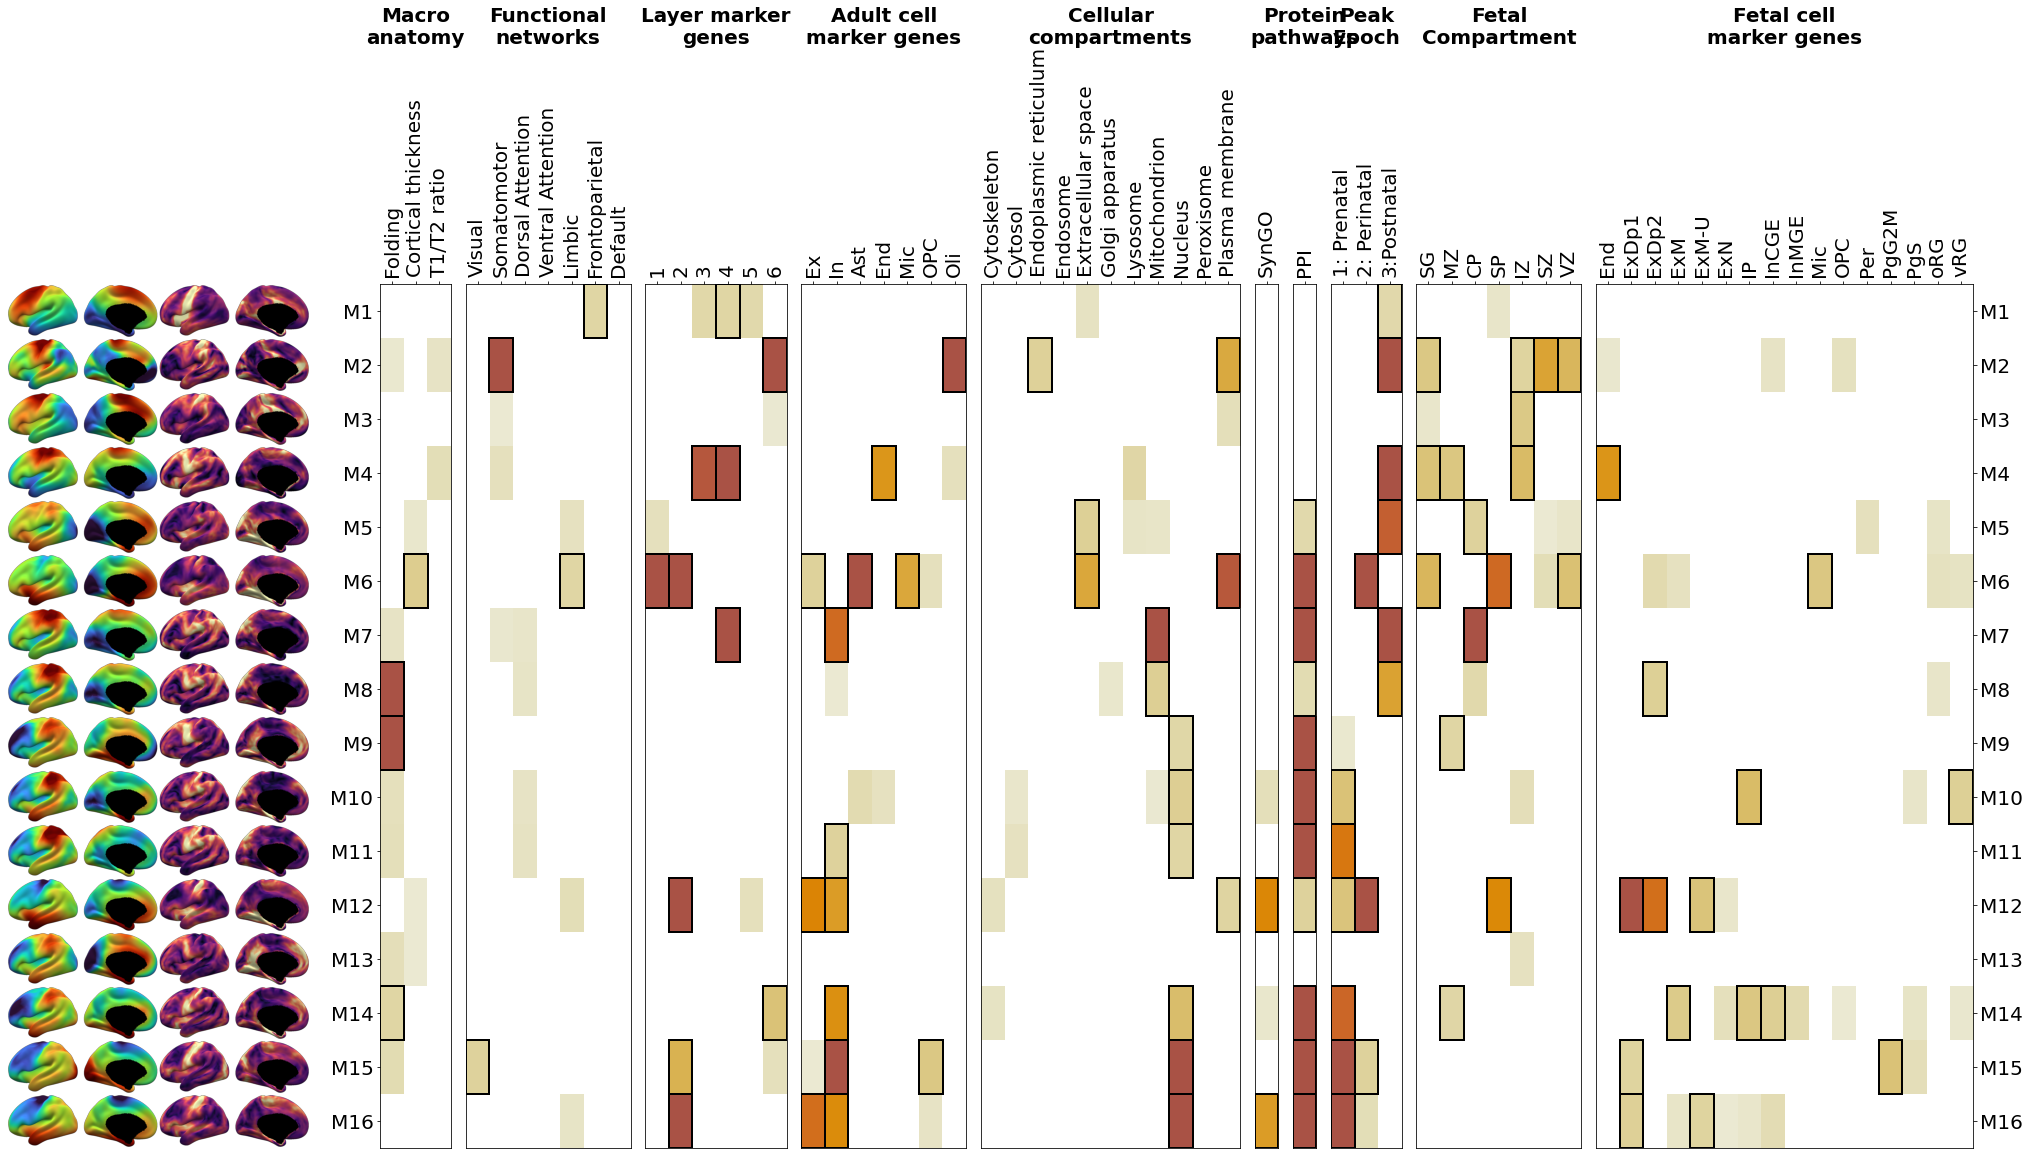

In [16]:
fig_combi = proc.main_fig(combi_matrices,combi_labels,
             proc.combined_eigengenes,
                module_labels,
                combi_under_labels,
                   combi_reorder,
             proc.new_order,
                         reflected_maps=False
            )
fig_combi.savefig('figures/adult_fetal_wgcna.pdf',bbox_inches='tight',
                     facecolor='white')